In [ ]:
!pip install -q datasets evaluate
!pip install fiftyone==0.23.0rc1
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install -q regex tqdm
!pip install -q diffusers transformers accelerate scipy
!pip install -q -U xformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import os
import fiftyone as fo
import shutil
import pandas as pd
import cv2
import random
import hashlib
from PIL import Image
import albumentations as A
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from transformers import TFSegformerForSemanticSegmentation
from transformers import create_optimizer
import torch
import numpy as np
from diffusers.utils import load_image, make_image_grid
import torch
from torchvision.transforms.functional import to_pil_image
from PIL import Image
import cv2
from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import copy
from diffusers import StableDiffusionInpaintPipeline, EulerDiscreteScheduler


Migrating database to v0.23.0rc1


INFO:fiftyone.migrations.runner:Migrating database to v0.23.0rc1
/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/usr/local/lib/python3.10/dist-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node ins

In [ ]:
H,W = 512,512
BATCH_SIZE = 2
N_CLASSES = 24
LR = 5e-5
N_EPOCHS = 20
WEIGHT_DECAY_RATE = 0.01
MEAN = [123.675, 116.28, 103.53]
STD = [58.395, 57.12, 57.375]
checkpoint_filepath = "/content/drive/MyDrive/fiftyone/segformer_b5_clothing.h5"

# Downloads

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d rajkumarl/people-clothing-segmentation

 99% 612M/616M [00:19<00:00, 26.8MB/s]
100% 616M/616M [00:19<00:00, 32.5MB/s]


In [ ]:
!unzip "/content/people-clothing-segmentation.zip" -d "/content/dataset/"

Archive:  /content/people-clothing-segmentation.zip
  inflating: /content/dataset/jpeg_images/IMAGES/img_0001.jpeg  
  inflating: /content/dataset/jpeg_images/IMAGES/img_0002.jpeg  
  inflating: /content/dataset/jpeg_images/IMAGES/img_0003.jpeg  
  inflating: /content/dataset/jpeg_images/IMAGES/img_0004.jpeg  
  inflating: /content/dataset/jpeg_images/IMAGES/img_0005.jpeg  
  inflating: /content/dataset/jpeg_images/IMAGES/img_0006.jpeg  
  inflating: /content/dataset/jpeg_images/IMAGES/img_0007.jpeg  
  inflating: /content/dataset/jpeg_images/IMAGES/img_0008.jpeg  
  inflating: /content/dataset/jpeg_images/IMAGES/img_0009.jpeg  
  inflating: /content/dataset/jpeg_images/IMAGES/img_0010.jpeg  
  inflating: /content/dataset/jpeg_images/IMAGES/img_0011.jpeg  
  inflating: /content/dataset/jpeg_images/IMAGES/img_0012.jpeg  
  inflating: /content/dataset/jpeg_images/IMAGES/img_0013.jpeg  
  inflating: /content/dataset/jpeg_images/IMAGES/img_0014.jpeg  
  inflating: /content/dataset/jpeg_ima

In [ ]:
df = pd.read_csv("/content/dataset/labels.csv")

In [ ]:
id2label = {}
for i,j in df.iterrows():
  if i==0:
    id2label[i] = 'nan'
  else:
    id2label[i] = j['label_list']

In [ ]:
label2id = {label: id for id,label in id2label.items()}

In [ ]:
print(label2id)
print(len(label2id))

{'nan': 0, 'accessories': 1, 'bag': 2, 'belt': 3, 'blazer': 4, 'blouse': 5, 'bodysuit': 6, 'boots': 7, 'bra': 8, 'bracelet': 9, 'cape': 10, 'cardigan': 11, 'clogs': 12, 'coat': 13, 'dress': 14, 'earrings': 15, 'flats': 16, 'glasses': 17, 'gloves': 18, 'hair': 19, 'hat': 20, 'heels': 21, 'hoodie': 22, 'intimate': 23, 'jacket': 24, 'jeans': 25, 'jumper': 26, 'leggings': 27, 'loafers': 28, 'necklace': 29, 'panties': 30, 'pants': 31, 'pumps': 32, 'purse': 33, 'ring': 34, 'romper': 35, 'sandals': 36, 'scarf': 37, 'shirt': 38, 'shoes': 39, 'shorts': 40, 'skin': 41, 'skirt': 42, 'sneakers': 43, 'socks': 44, 'stockings': 45, 'suit': 46, 'sunglasses': 47, 'sweater': 48, 'sweatshirt': 49, 'swimwear': 50, 't-shirt': 51, 'tie': 52, 'tights': 53, 'top': 54, 'vest': 55, 'wallet': 56, 'watch': 57, 'wedges': 58}
59


# Data Preparation

In [ ]:
im_path = "/content/dataset/png_images/IMAGES/"
anno_path = "/content/dataset/png_masks/MASKS/"
val_im_path = "/content/val_dataset/png_images/IMAGES/"
val_anno_path = "/content/val_dataset/png_masks/MASKS/"

In [ ]:
for fname in os.listdir(anno_path):
  os.rename(anno_path+fname,anno_path+"img"+fname[3:])

## Split Data

In [ ]:
!mkdir /content/val_dataset/
!mkdir /content/val_dataset/png_images/
!mkdir /content/val_dataset/png_masks/
!mkdir /content/val_dataset/png_images/IMAGES/
!mkdir /content/val_dataset/png_masks/MASKS/

In [ ]:
val_list=["0115","0025","0010","0003","0125","0200","0515","0225","0805","0915","0630","0301","0112","0905","0823","0527","0088","0055","0018",
          "0222","0049","0273","0299","0282","0372","0027","0445","0582","0374","0956","0211","0019","0961","0397","0699","0789","0996","0290",
          "0110","0315","0335","0419","0666","0525","0927","0555","0275","0855","0815","0130","0371","0412","0105","0423","0507","0028","0035","0118",
          "0232","0849","0673","0688","0777","0472","0991","0485","0592","0334","0827","0651","0619","0567","0393","0609","0719","0916","0190",
          ]

In [ ]:
import shutil

In [ ]:
for name in val_list:
  shutil.move(im_path+"img_"+name+".png", val_im_path+"img_"+name+".png")
  shutil.move(anno_path+"img_"+name+".png", val_anno_path+"img_"+name+".png")

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    ([im_path+i for i in os.listdir(im_path)],
    [anno_path+"img"+i[3:] for i in os.listdir(im_path)])
)
val_dataset = tf.data.Dataset.from_tensor_slices(
    ([val_im_path+i for i in os.listdir(val_im_path)],
    [val_anno_path+"img"+i[3:] for i in os.listdir(val_im_path)])
)

In [ ]:
for i in train_dataset.take(3):
  print(i)

(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/dataset/png_images/IMAGES/img_0795.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/dataset/png_masks/MASKS/img_0795.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/dataset/png_images/IMAGES/img_0365.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/dataset/png_masks/MASKS/img_0365.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/dataset/png_images/IMAGES/img_0149.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/dataset/png_masks/MASKS/img_0149.png'>)


In [ ]:
for i in val_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/val_dataset/png_images/IMAGES/img_0507.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/val_dataset/png_masks/MASKS/img_0507.png'>)


In [ ]:
len(train_dataset)

923

In [ ]:
len(val_dataset)

77

## Preprocess Data

In [ ]:
MEAN = [123.675, 116.28, 103.53]
STD = [58.395, 57.12, 57.375]


In [ ]:
def preprocess(im_path, anno_path):
  img = tf.io.decode_jpeg(tf.io.read_file(im_path))
  img = tf.cast(img,tf.float32)
  img = (img-MEAN)/STD

  anno = tf.io.decode_jpeg(tf.io.read_file(anno_path))
  anno = tf.cast(tf.squeeze(anno,-1),tf.float32)

  return img, anno

In [ ]:
prep_train_ds = (
    train_dataset
    .map(preprocess,num_parallel_calls=tf.data.AUTOTUNE)
)
prep_val_ds = (
    val_dataset
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
)

In [ ]:
for i,j in prep_train_ds.take(1):
  print(i.shape,j.shape)

(825, 550, 3) (825, 550)


## Data Augmentation

In [ ]:
H,W = 512,512

In [ ]:
transform = A.Compose([
    A.RandomCrop (H,W, p=1.0),
    A.HorizontalFlip(p=0.3),
    A.VerticalFlip(p=0.3),
    A.RandomRotate90(p=0.3),
    A.Transpose(p=0.3),
    A.Sharpen (alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=0.1),
    A.RandomShadow (shadow_roi=(0, 0.5, 1, 1),
                    num_shadows_lower=1, num_shadows_upper=2,
                    shadow_dimension=5, p=0.1),
    A.RandomBrightnessContrast(p=0.2),
    #A.Resize(H,W),
])

val_transform = A.Compose([
    A.Resize(H,W),
])

In [ ]:
def aug_albument(image,mask):
  augmented = transform(image=image, mask=mask)
  return [tf.convert_to_tensor(augmented["image"],dtype=tf.float32),
          tf.convert_to_tensor(augmented["mask"], dtype=tf.float32)]
def val_aug_albument(image,mask):
  augmented = val_transform(image=image, mask=mask)
  return [tf.convert_to_tensor(augmented["image"],dtype=tf.float32),
          tf.convert_to_tensor(augmented["mask"], dtype=tf.float32)]

In [ ]:
def augment(image,mask):
  aug_output = tf.numpy_function(func=aug_albument, inp=[image,mask], Tout=[tf.float32,tf.float32])
  return {"pixel_values":tf.transpose(aug_output[0],(2,0,1)), "labels":aug_output[1]}

def val_augment(image,mask):
  aug_output = tf.numpy_function(func=val_aug_albument, inp=[image,mask], Tout=[tf.float32,tf.float32])
  return {"pixel_values":tf.transpose(aug_output[0],(2,0,1)), "labels":aug_output[1]}


In [ ]:
BATCH_SIZE = 2
train_ds = (
    prep_train_ds
    .shuffle(10)
    .map(augment,num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
val_ds = (
    prep_val_ds
    .map(val_augment,num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
for i in train_ds.take(1):
  data = i

  print(i)

{'pixel_values': <tf.Tensor: shape=(2, 3, 512, 512), dtype=float32, numpy=
array([[[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         ...,
         [ 0.15223941,  0.05326121,  0.0037721 , ...,  0.06975758,
           0.03676484,  0.02026847],
         [ 0.03676484,  0.05326121,  0.10275032, ...,  0.10275032,
           0.11924668,  0.        ],
         [ 0.        ,  0.03676484,  0.11924668, ...,  0.16873579,
           0.18523216,  0.16873579]],

        [[ 0.        ,  0.02668151,  0.00981691, ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.02668151,  0.0435461 , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.02668151, ...,  0.        ,
          

## Data Visualization

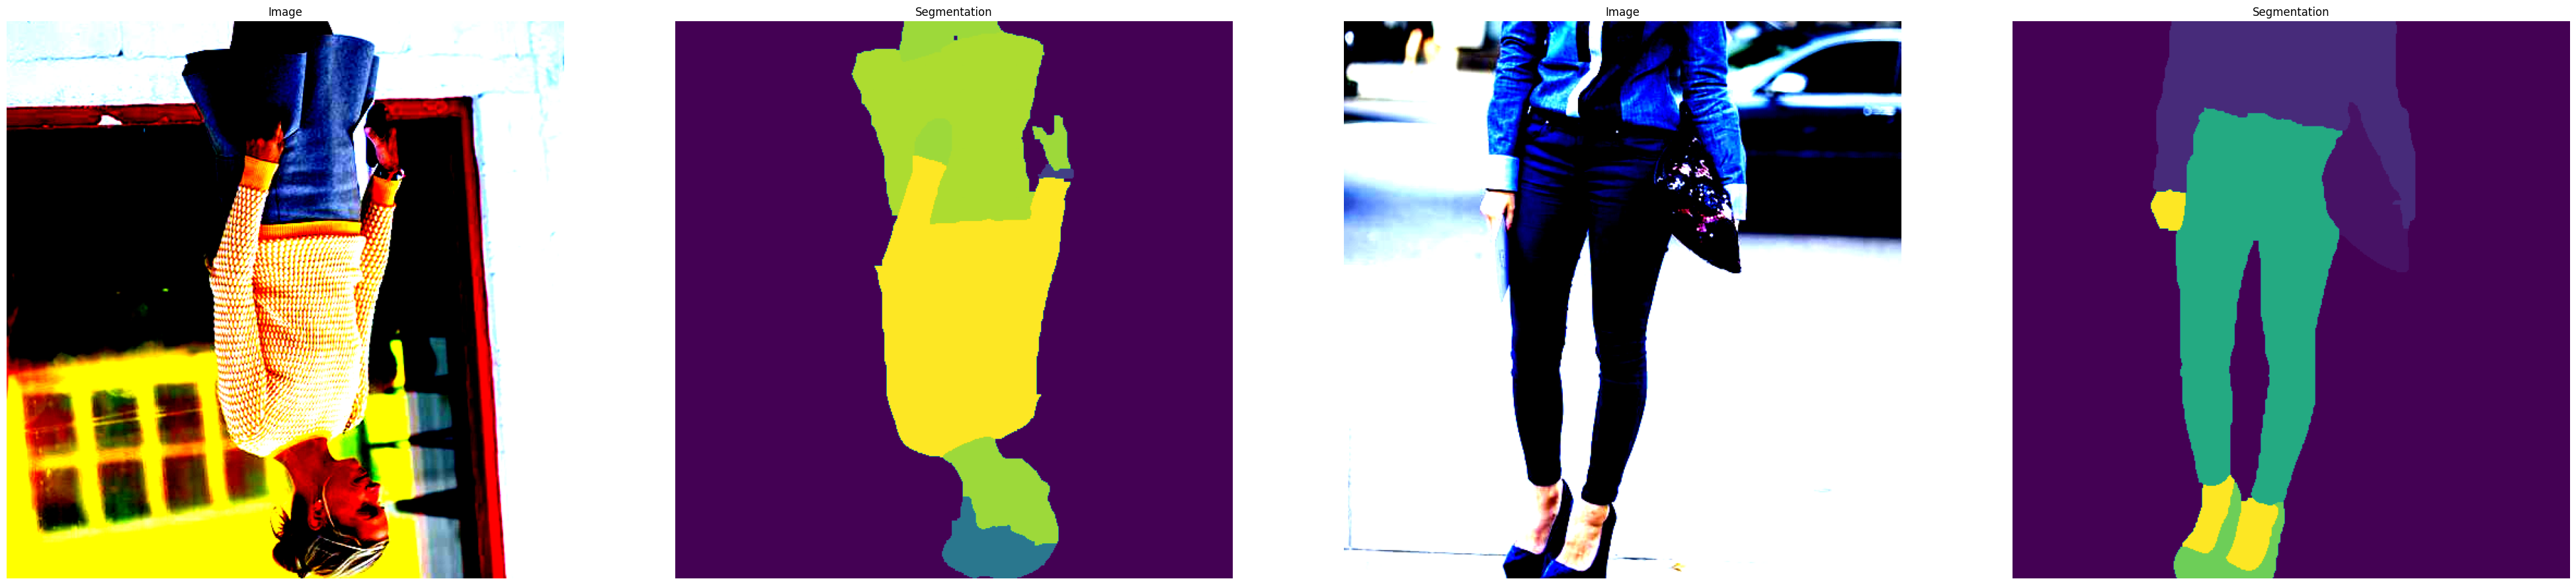

In [ ]:
plt.figure(figsize = (50,50))

for data in train_ds.take(1):
  images=data['pixel_values']
  labels=data['labels']
  for i in range(BATCH_SIZE*2):
    if i==4:
      break
    ax = plt.subplot(1,BATCH_SIZE*2, i+1)
    if i%2==0:
      plt.imshow(tf.transpose(images[i//2], (1, 2, 0)))
      plt.title("Image")
    else:
      plt.imshow(labels[i//2])
      plt.title("Segmentation")
    plt.axis("off")
  plt.show()

# WOrking with Voxel51

In [ ]:
name = "clothing-dataset-1"
data_path = "/content/val_dataset/png_images/IMAGES"
labels_path = "/content/val_dataset/png_masks/MASKS"
# Create the dataset
dataset = fo.Dataset.from_dir(
    data_path=data_path,
    labels_path=labels_path,
    dataset_type=fo.types.ImageSegmentationDirectory,
    name=name,
)

# View summary info about the dataset
print(dataset)

# Print the first few samples in the dataset
print(dataset.head())

 100% |███████████████████| 77/77 [94.5ms elapsed, 0s remaining, 814.8 samples/s]  


INFO:eta.core.utils: 100% |███████████████████| 77/77 [94.5ms elapsed, 0s remaining, 814.8 samples/s]  


Name:        clothing-dataset-1
Media type:  image
Num samples: 77
Persistent:  False
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Segmentation)
[<Sample: {
    'id': '65d6ee97c605f3292f7c8e34',
    'media_type': 'image',
    'filepath': '/content/val_dataset/png_images/IMAGES/img_0003.png',
    'tags': [],
    'metadata': None,
    'ground_truth': <Segmentation: {
        'id': '65d6ee97c605f3292f7c8e33',
        'tags': [],
        'mask': None,
        'mask_path': '/content/val_dataset/png_masks/MASKS/img_0003.png',
    }>,
}>, <Sample: {
    'id': '65d6ee97c605f3292f7c8e37',
    'media_type': 'image',
    'filepath': '/content/val_da

In [ ]:
print(dataset.tail())

[<Sample: {
    'id': '65d6ee97c605f3292f7c8eca',
    'media_type': 'image',
    'filepath': '/content/val_dataset/png_images/IMAGES/img_0961.png',
    'tags': [],
    'metadata': None,
    'ground_truth': <Segmentation: {
        'id': '65d6ee97c605f3292f7c8ebc',
        'tags': [],
        'mask': None,
        'mask_path': '/content/val_dataset/png_masks/MASKS/img_0961.png',
    }>,
}>, <Sample: {
    'id': '65d6ee97c605f3292f7c8ecb',
    'media_type': 'image',
    'filepath': '/content/val_dataset/png_images/IMAGES/img_0991.png',
    'tags': [],
    'metadata': None,
    'ground_truth': <Segmentation: {
        'id': '65d6ee97c605f3292f7c8ebd',
        'tags': [],
        'mask': None,
        'mask_path': '/content/val_dataset/png_masks/MASKS/img_0991.png',
    }>,
}>, <Sample: {
    'id': '65d6ee97c605f3292f7c8ecc',
    'media_type': 'image',
    'filepath': '/content/val_dataset/png_images/IMAGES/img_0996.png',
    'tags': [],
    'metadata': None,
    'ground_truth': <Segmentat

## Download Plugins

In [ ]:
!fiftyone plugins download https://github.com/voxel51/fiftyone-plugins --plugin-names @voxel51/plugins


Copying plugin '@voxel51/plugins' to '/root/fiftyone/__plugins__/@voxel51/plugins'


In [ ]:
!fiftyone plugins download https://github.com/Neuralearn/data_augment --plugin-names @Neuralearn/data_augment


Copying plugin '@Neuralearn/data_augment' to '/root/fiftyone/__plugins__/@Neuralearn/data_augment'


## Evaluation with FiftyOne

In [ ]:
H_resized, W_resized = 512,512
H_init, W_init = 825,550
import evaluate
metric = evaluate.load("mean_iou")

In [ ]:
for i,sample in enumerate(dataset):

  img = tf.io.decode_jpeg(tf.io.read_file(sample.filepath))
  img = tf.image.resize(img, (H_resized, W_resized))
  img = tf.cast(img,tf.float32)
  img = (img-MEAN)/STD
  img = tf.transpose(img, (2,0,1))
  img = tf.expand_dims(img, axis=0)

  output = model(img).logits
  output = tf.argmax(output, axis=1)

  resized_output = tf.image.resize(
      tf.expand_dims(output,axis=-1),(H_init, W_init), method="bilinear", antialias=True)
  resized_output = tf.cast(tf.squeeze(resized_output, axis=-1),dtype=tf.uint8)[0]
  sample["pred"] = fo.Segmentation(mask=resized_output.numpy())

  mask = cv2.imread(sample["ground_truth"]["mask_path"], cv2.IMREAD_GRAYSCALE)
  metrics = metric.compute(
      predictions = [resized_output.numpy()],
      references = [mask],
      num_labels = len(label2id),
      ignore_index = 0,
      nan_to_num=0,
      reduce_labels=False
  )


  sample["mean_iou"] = metrics["mean_iou"]
  sample["mean_accuracy"] = metrics["mean_accuracy"]
  sample["overall_accuracy"] = metrics["overall_accuracy"]

  for k,c in enumerate(metrics["per_category_iou"]):
    if c>0.0001:
      key = id2label[k]+"_iou"### e.g. shoes_iou
      sample[key] = c

  sample.save()

In [ ]:
model(tf.ones([1,3,512,512])).logits.shape

TensorShape([1, 59, 128, 128])

## Viz

In [ ]:
dataset.default_mask_targets = id2label
session = fo.launch_app(dataset,port=51)

# Modeling

In [ ]:
model_id = "nvidia/segformer-b5-finetuned-cityscapes-1024-1024"
model = TFSegformerForSemanticSegmentation.from_pretrained(
    model_id,
    num_labels = len(label2id),
    id2label = id2label,
    label2id = label2id,
    ignore_mismatched_sizes = True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/340M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFSegformerForSemanticSegmentation.

Some weights of TFSegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b5-finetuned-cityscapes-1024-1024 and are newly initialized because the shapes did not match:
- decode_head/classifier/kernel:0: found shape (1, 1, 768, 19) in the checkpoint and (1, 1, 768, 59) in the model instantiated
- decode_head/classifier/bias:0: found shape (19,) in the checkpoint and (59,) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.summary()

Model: "tf_segformer_for_semantic_segmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 segformer (TFSegformerMain  multiple                  81443008  
 Layer)                                                          
                                                                 
 decode_head (TFSegformerDe  multiple                  3197243   
 codeHead)                                                       
                                                                 
Total params: 84640251 (322.88 MB)
Trainable params: 84638715 (322.87 MB)
Non-trainable params: 1536 (6.00 KB)
_________________________________________________________________


In [ ]:
model(tf.zeros([1,3,H,W])).logits.shape

TensorShape([1, 59, 128, 128])

In [ ]:
model.load_weights(checkpoint_filepath)

# Training and Evaluation

In [ ]:
import evaluate
metric = evaluate.load("mean_iou")

In [ ]:
model(tf.zeros([1,3,H,W])).logits.shape

TensorShape([1, 59, 128, 128])

In [ ]:
512,512

(512, 512)

In [ ]:
def compute_metrics(eval_pred):
  logits, labels = eval_pred
  logits = tf.transpose(logits, perm=[0,2,3,1])
  logits_resized =tf.image.resize(
      logits,
      size=tf.shape(labels)[1:],
      method="bilinear"
  )
  pred_labels = tf.argmax(logits_resized, axis=-1)

  metrics = metric.compute(
      predictions = pred_labels,
      references = labels,
      num_labels = len(label2id),
      ignore_index = 0,
  )

  per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
  per_category_iou = metrics.pop("per_category_iou").tolist()

  metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
  metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

  return {"val_" + k: v for k, v in metrics.items()}

In [ ]:
batch_size = 2
num_epochs = 15
num_train_steps = len(train_ds) * num_epochs
learning_rate = 6e-5
weight_decay_rate = 0.01

optimizer, lr_schedule = create_optimizer(
    init_lr=learning_rate,
    num_train_steps=num_train_steps,
    weight_decay_rate=weight_decay_rate,
    num_warmup_steps=0,
)

In [ ]:
from transformers.keras_callbacks import KerasMetricCallback

metric_callback = KerasMetricCallback(
    metric_fn=compute_metrics,
    eval_dataset=val_ds,
    batch_size=batch_size,
    label_cols=["labels"]
)
callbacks = [metric_callback]

In [ ]:
model.compile(optimizer=optimizer)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=num_epochs,
    callbacks=callbacks,
)

Epoch 1/15
462/462 [==============================] - 571s 899ms/step - loss: 0.7066 - val_loss: 0.4540 - val_mean_iou: 0.0876 - val_mean_accuracy: 0.1410 - val_overall_accuracy: 0.4555 - val_accuracy_nan: nan - val_accuracy_accessories: 0.0000e+00 - val_accuracy_bag: 0.7964 - val_accuracy_belt: 0.0000e+00 - val_accuracy_blazer: 4.7215e-05 - val_accuracy_blouse: 0.3201 - val_accuracy_bodysuit: 0.0000e+00 - val_accuracy_boots: 0.0000e+00 - val_accuracy_bra: nan - val_accuracy_bracelet: 0.0000e+00 - val_accuracy_cape: 0.0000e+00 - val_accuracy_cardigan: 0.0000e+00 - val_accuracy_clogs: nan - val_accuracy_coat: 0.8355 - val_accuracy_dress: 0.2780 - val_accuracy_earrings: nan - val_accuracy_flats: 0.0000e+00 - val_accuracy_glasses: 0.0000e+00 - val_accuracy_gloves: 0.0000e+00 - val_accuracy_hair: 0.7815 - val_accuracy_hat: 0.0000e+00 - val_accuracy_heels: 0.0000e+00 - val_accuracy_hoodie: nan - val_accuracy_intimate: nan - val_accuracy_jacket: 0.0000e+00 - val_accuracy_jeans: 0.6383 - val_

In [ ]:

model.save_weights(checkpoint_filepath)

# Generating New Samples

## Image Editing

In [ ]:
H_resized,W_resized = 512,512
H_init,W_init = 825,550

In [ ]:
def generate_inputs(im_path, mask_label):
  mask_id = label2id[mask_label]
  source_image = cv2.imread(im_path)

  img = tf.io.decode_jpeg(tf.io.read_file(im_path))
  img = tf.image.resize(img, (H_resized, W_resized))
  img = tf.cast(img, tf.float32)
  img = (img-MEAN)/STD
  img = tf.transpose(img, (2,0,1))
  img = tf.expand_dims(img, axis=0)

  output = model(img).logits

  output = tf.argmax(output, axis=1)

  resized_output = tf.image.resize(
      tf.expand_dims(output,axis=-1),(H_init, W_init), method="bilinear", antialias=True)
  resized_output = tf.cast(tf.squeeze(resized_output, axis=-1),dtype=tf.uint8)[0].numpy()
  mask = resized_output+(-mask_id*np.ones_like(resized_output))

  mask = 255-np.clip(1e10*np.multiply(mask,mask),a_min=0, a_max=255)
  cv2.imwrite("mask.jpg", mask)

  return Image.fromarray(source_image), Image.fromarray(mask)

In [ ]:
generate_inputs("/content/val_dataset/png_images/IMAGES/img_0003.png","coat")

(<PIL.Image.Image image mode=RGB size=550x825>,
 <PIL.Image.Image image mode=F size=550x825>)

In [ ]:
from diffusers import StableDiffusionInpaintPipeline
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
)
pipe.to("cuda")
pipe.enable_xformers_memory_efficient_attention()

  0%|          | 0/50 [00:00<?, ?it/s]

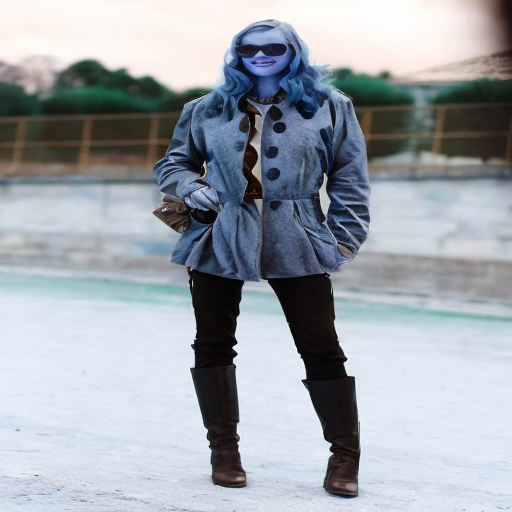

In [ ]:
prompt = "A photorealistic photo of a woman wearing a green-colored nice looking coat all green high resolution"
#image and mask_image should be PIL images.
#The mask structure is white for inpainting and black for keeping as is
image, mask_image = generate_inputs(
    "/content/val_dataset/png_images/IMAGES/img_0003.png","coat")

image = pipe(prompt=prompt, image=image, mask_image=mask_image, ).images[0]
image.resize((W_init, H_init))
display(image.resize((550,825)))

## Data AUgmentation

In [ ]:
model_id = "stabilityai/stable-diffusion-2-inpainting"

In [ ]:
def create_pipeline(model_id):
  scheduler = EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
  pipe = StableDiffusionInpaintPipeline.from_pretrained(model_id,
                                                        scheduler=scheduler,
                                                        revision="fp16",
                                                        torch_dtype=torch.float16)

  pipe = pipe.to("cuda")
  pipe.enable_xformers_memory_efficient_attention()
  return pipe

In [ ]:
pipeline = create_pipeline(model_id)

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/pipeline_utils.py:270: FutureWarning: You are loading the variant fp16 from stabilityai/stable-diffusion-2-inpainting via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(
text_encoder/model.safetensors not found


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [ ]:
from torchvision import transforms
def generate_inputs(im_path,mask_path, mask_id):
  #source_image = cv2.imread(im_path)
  source_image = Image.open(im_path)
  source_image = img.convert("RGB")
  sd_mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)

  out = (sd_mask+(-mask_id*np.ones_like(sd_mask)))
  mask=-(np.clip(1e10*np.multiply(out,out),a_min=0,a_max=255)-255)
  cv2.imwrite("mask.jpg", mask)
  pil_image = source_image.resize((512,512))
  pil_mask = Image.fromarray(mask).resize((512,512))

  return pil_image, pil_mask

In [ ]:
def augpaint(pipe, prompt, pil_image, pil_mask, guidance_scale, num_inference_steps):

  num_images_per_prompt = 1
  generator = torch.Generator(device="cuda").manual_seed(10)

  encoded_images = []

  for i in range(num_images_per_prompt):
    image = pipe(prompt=prompt, guidance_scale=guidance_scale,
                  num_inference_steps=num_inference_steps, generator=generator,
                  image=pil_image, mask_image=pil_mask, strength=0.99).images[0]



    encoded_images.append(image.resize((550,825)))
  return encoded_images[0]

In [ ]:

def create_hash():
  randint = random.randint(0, 100000000)
  hash = hashlib.sha256(str(randint).encode("utf-8")).hexdigest()[:10]
  return hash

In [ ]:
create_hash()

'ca34dee514'

In [ ]:
def list_classes(mask_path):

  mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
  list_unique = np.unique(mask)
  return list_unique

In [ ]:
guidance_scale = 8
num_inference_steps = 25


val_im_path = "/content/val_dataset/png_images/IMAGES/"
val_anno_path = "/content/val_dataset/png_masks/MASKS/"

In [ ]:
dataset.head()

[<Sample: {
     'id': '65d62bf37ba142b66e64bcbf',
     'media_type': 'image',
     'filepath': '/content/val_dataset/png_images/IMAGES/img_0003.png',
     'tags': [],
     'metadata': None,
     'ground_truth': <Segmentation: {
         'id': '65d62bf37ba142b66e64bcbe',
         'tags': [],
         'mask': None,
         'mask_path': '/content/val_dataset/png_masks/MASKS/img_0003.png',
     }>,
 }>,
 <Sample: {
     'id': '65d62bf37ba142b66e64bcc2',
     'media_type': 'image',
     'filepath': '/content/val_dataset/png_images/IMAGES/img_0010.png',
     'tags': [],
     'metadata': None,
     'ground_truth': <Segmentation: {
         'id': '65d62bf37ba142b66e64bcc0',
         'tags': [],
         'mask': None,
         'mask_path': '/content/val_dataset/png_masks/MASKS/img_0010.png',
     }>,
 }>,
 <Sample: {
     'id': '65d62bf37ba142b66e64bcc3',
     'media_type': 'image',
     'filepath': '/content/val_dataset/png_images/IMAGES/img_0018.png',
     'tags': [],
     'metadata': None,

In [ ]:
def transform_sample(sample, select_class, prompt):
  hash = create_hash()
  filename = sample.filepath.split("/")[-1][:-4]+"_"+str(hash)+".png"
  pipe = pipeline

  im,mask = generate_inputs(
      sample.filepath, sample.ground_truth.mask_path,
      label2id[select_class])

  out = augpaint(pipe, prompt, im, mask, guidance_scale, num_inference_steps)

  #cv2.imwrite(sample.filepath[:-4]+"_"+str(hash)+".png",
   #           np.array(out))
  im_saved = out.save(sample.filepath[:-4]+"_"+str(hash)+".png")

  shutil.copy(sample.ground_truth.mask_path,
              sample.ground_truth.mask_path[:-4]+"_"+str(hash)+".png",
              )

  display(out)

  new_sample = fo.Sample(
    filepath=sample.filepath[:-4]+"_"+str(hash)+".png",
    ground_truth=fo.Segmentation(
        mask_path=sample.ground_truth.mask_path[:-4]+"_"+str(hash)+".png"),
  )

  return new_sample

  0%|          | 0/24 [00:00<?, ?it/s]

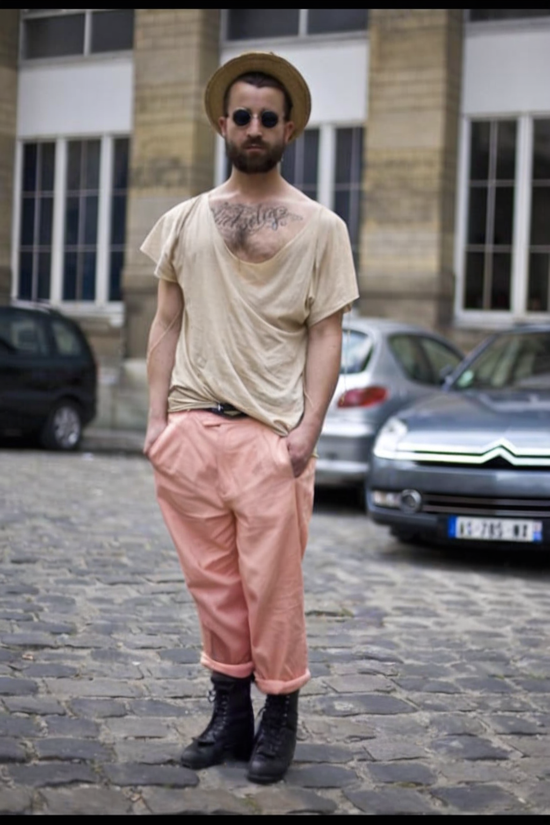

In [ ]:
for sample in dataset:
  if sample.id == '65d62bf37ba142b66e64bcbf':
    new_sample = transform_sample(sample, "boots", "A photorealistic photo of a woman wearing a red-colored nice looking boot all red  high resolution")
    dataset.add_sample(new_sample)
  #break